# Install Important Libraries

In [11]:
# import torch

# def format_pytorch_version(version):
#     return version.split('+')[0]

# TORCH_version = torch.__version__
# TORCH = format_pytorch_version(TORCH_version)

# def format_cuda_version(version):
#     return 'cu' + version.replace('.', '')

# CUDA_version = torch.version.cuda
# # CUDA_version = TORCH_version.cuda

# CUDA = format_cuda_version(CUDA_version)
# !pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-geometric
# !pip install torch_geometric

# Import Libraries

In [12]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils.convert import from_networkx

import math
import time

import torch

from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

random_seed = 7
#set the random seeds 
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

# Dataset Preprocessing


In [19]:
def load_data(season_no):

  #read the edge and node files
  dir = "./../data/nodes_edges/"
  edge_file = dir + "got-s" + str(season_no) + "-edges.csv"
  node_file = dir + "got-s" + str(season_no) + "-m-nodes.csv"

  edges = pd.read_csv(edge_file)
  nodes = pd.read_csv(node_file)
  
  #only get those edges where the nodes are present
  node_ids = nodes['CHARACTERS ID']
  node_ids_reverse = node_ids.to_dict()
  node_ids = {v: k for k, v in node_ids_reverse.items()}
  
  #remove unnecessary columns
  # features = nodes.drop(['CHARACTERS ID'], axis=1)
  features = nodes.loc[:, ['King', 'Death', 'War']]
  features = torch.from_numpy(features.to_numpy().astype(np.float32))
  torch.where(features)
  edges = edges.drop(['Season'], axis=1)
  
  #Adjacency matrix
  gr = nx.Graph()
  adj = np.zeros( (len(node_ids),len(node_ids)) )

  for i in range(len(edges)):
    if edges.iloc[i]['Source'] in node_ids and edges.iloc[i]['Target'] in node_ids:
      src_index = node_ids[edges.iloc[i]['Source']]
      dst_index = node_ids[edges.iloc[i]['Target']]
      gr.add_edge(src_index, dst_index, weight=edges.iloc[i]['Weight'])
      adj[src_index][dst_index] = edges.iloc[i]['Weight']
      adj[dst_index][src_index] = edges.iloc[i]['Weight']


  adj = torch.from_numpy(adj.astype(np.float32))
  print("adj max is {}".format(adj.max()))

  return features, adj, gr, node_ids

# Per Season Graph

In [20]:
per_season_graph = []
per_season_adj = []
per_season_nodes = []
per_season_features = []
per_season_pyg_data = []
per_season_normalized_adj = []

def normalize_adj(adj):
    return adj / adj.sum()

for i in range(1,9):
    features, adj, graph, node_ids = load_data(i)
    per_season_graph.append(graph)
    per_season_adj.append(adj)
    per_season_nodes.append(node_ids)
    per_season_features.append(features)
    per_season_pyg_data.append(from_networkx(graph))
    per_season_normalized_adj.append(normalize_adj(adj))

adj max is 192.0
adj max is 177.0
adj max is 159.0
adj max is 147.0
adj max is 141.0
adj max is 151.0
adj max is 179.0
adj max is 194.0


# Generative Model

## Encoder

In [23]:
from torch_geometric.nn import GCNConv

class Encoder(nn.Module):
  def __init__(self, nfeat, nhid, nembed):
    super(Encoder, self).__init__()

    self.conv = GCNConv(nfeat, nhid)
    self.mean_finder = GCNConv(nhid, nhid)
    self.logstd_finder = GCNConv(nhid, nhid)

    self.mean_process = nn.Linear(42*nhid,nembed)
    self.std_process = nn.Linear(42*nhid,nembed)  

    self.nhid = nhid
    self.nembed = nembed

  def forward(self, x, edge_ids, edge_weight):
    x = F.relu(self.conv(x, edge_ids, edge_weight))

    self.mean = F.relu(self.mean_finder(x, edge_ids, edge_weight))
    self.mean = self.mean_process(torch.flatten(self.mean).reshape(1,42*self.nhid))

    self.logstd = F.relu(self.logstd_finder(x, edge_ids, edge_weight))
    self.logstd = torch.exp( self.std_process(torch.flatten(self.logstd).reshape(1,42*self.nhid)) )
    
    gaussian_noise = torch.randn_like(self.mean)
    sampled_z = gaussian_noise*self.logstd + self.mean
    return sampled_z

  def kl_div(self):
    kl = -0.5 * torch.mean(
            torch.sum(1 + 2 * self.logstd - self.mean**2 - self.logstd.exp()**2, dim=1))
    return kl

  def kl_loss(self):
    kl_div = -0.5 * torch.mean(torch.sum(1 + 2 * self.logstd - self.mean**2 - self.logstd.exp()**2, dim=1))
    
    return kl_div

## Decoder

In [24]:
from torch_geometric.nn.models import InnerProductDecoder, VGAE

class Decoder(nn.Module):
  def __init__(self, latent_dim):
    super(Decoder, self).__init__()

    self.linear1 = nn.Linear(latent_dim, latent_dim)
    self.t = int( ( (42 * 42) - 42 ) / 2)

    #node attributes
    self.node_death = nn.Linear(latent_dim, 42)
    self.node_king  = nn.Linear(latent_dim, 42)
    self.node_war   = nn.Linear(latent_dim, 42)

    #adjacency 
    self.adjacency_finder = nn.Linear(latent_dim, self.t)

  def decode(self, x):
    x = F.relu(self.linear1(x))
    death = F.sigmoid(self.node_death(x))
    war = F.sigmoid(self.node_war(x))
    king = F.sigmoid(self.node_king(x))

    #adjacency
    adj = self.adjacency_finder(x)  # regression

    return death, war, king, adj

## Model

In [25]:
from torch_geometric.utils import negative_sampling, remove_self_loops, add_self_loops

class DeepVGAE(nn.Module):
  def __init__(self):
    super(DeepVGAE, self).__init__()
    self.encoder = Encoder(nfeat=3, nhid=10, nembed=10)
    self.decoder = Decoder(10)

  def do_it(self, x, edge_ids, edge_weight):
    z = self.encoder(x, edge_ids, edge_weight)
    self.kl_loss = self.encoder.kl_div()
    
    death, war, king, adj = self.decoder.decode(z)
    return death, war, king, adj

## Calculate the Losses

In [26]:
    
def get_the_upper(actual_adj):
    upper_size = int( ( (42 * 42) - 42 ) / 2)
    uppers = torch.zeros((upper_size, 1))

    k = 0
    for i in range(42-1):
        for j in range(i+1, 42):
            uppers[k][0] = actual_adj[i][j]
            k += 1

    return uppers

def losses(death, war, king, adj, actual_features, actual_adj):
    l1 = F.binary_cross_entropy_with_logits(king, actual_features[:,0].reshape(1,42)).sum() 
    l2 = F.binary_cross_entropy_with_logits(death, actual_features[:,1].reshape(1,42)).sum() 
    l3 = F.binary_cross_entropy_with_logits(war, actual_features[:,2].reshape(1,42)).sum()

    uppers = get_the_upper(actual_adj)
    upper_size = int( ( (42 * 42) - 42 ) / 2)

    # l4 = F.binary_cross_entropy_with_logits(adj.reshape(adj.shape[1],1), torch.where(uppers > 0, 1.0, 0.0)).sum()
    l4 = F.mse_loss(adj.reshape(adj.shape[1],1), uppers)

    return l1+l2+l3+l4

# Model Training

## Create the Model and Intiallize the optimizer

In [27]:
model = DeepVGAE()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [28]:
from tqdm import tqdm

#Give the input graph to the VGAE
overall_loss = []
reconstruction_loss = []
kl_loss = []

EPOCHS = 1000
model.train()
for epoch in range(EPOCHS):
    for i in range(6):

        optimizer.zero_grad()
        #Inference
        death, war, king, adj = model.do_it(per_season_features[i],
                                             per_season_pyg_data[i].edge_index,
                                             per_season_pyg_data[i].weight.type(torch.float32))
        
        #find reconstruction loss
        loss = losses(death, war, king, adj, per_season_features[i+1], per_season_adj[i+1])
        reconstruction_loss.append(loss.clone().detach().numpy())

        #find kl loss
        kl_divergence = 0.4 * model.kl_loss
        
        kl_loss.append(kl_divergence.clone().detach().numpy())

        #add recon_loss + kl_loss
        loss += kl_divergence
        overall_loss.append(loss.clone().detach().numpy())


        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
        optimizer.step()

    if epoch % 50 == 0:
        print(f"\tEpoch: {epoch},\tLoss: {loss}")
    elif epoch == EPOCHS-1:
        print(f"\tEpoch: {epoch},\tLoss: {loss}")

/usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


	Epoch: 0,	Loss: 233.1389617919922
	Epoch: 50,	Loss: 147.72921752929688
	Epoch: 100,	Loss: 48.24762725830078
	Epoch: 150,	Loss: 24.265716552734375
	Epoch: 200,	Loss: 8.520672798156738
	Epoch: 250,	Loss: 6.585599899291992
	Epoch: 300,	Loss: 5.834281921386719
	Epoch: 350,	Loss: 4.6381683349609375
	Epoch: 400,	Loss: 5.240733623504639
	Epoch: 450,	Loss: 3.7427000999450684
	Epoch: 500,	Loss: 3.4529521465301514
	Epoch: 550,	Loss: 3.8180108070373535
	Epoch: 600,	Loss: 3.644986867904663
	Epoch: 650,	Loss: 3.616799831390381
	Epoch: 700,	Loss: 2.9456913471221924
	Epoch: 750,	Loss: 2.85665225982666
	Epoch: 800,	Loss: 2.863419771194458
	Epoch: 850,	Loss: 2.7621469497680664
	Epoch: 900,	Loss: 2.9096667766571045
	Epoch: 950,	Loss: 2.605452299118042
	Epoch: 999,	Loss: 2.5438036918640137


# Analysis

## Get the rank

In [29]:
def get_ranking(G, n_rank):
    dc = dict(G.degree())
    wdc = dict(G.degree(weight='weight'))
    ec = nx.eigenvector_centrality(G, weight='weight')
    pg = nx.pagerank(G, weight='weight')
    bc = nx.betweenness_centrality(G, k=10, endpoints=True, weight=None)
    for n in G.nodes():
        ec[n] = round(ec[n], 3)
        pg[n] = round(pg[n], 3)
        bc[n] = round(bc[n], 3)

    dict_list = [dc, wdc, ec, pg, bc]
    ranking = {}
    for d in dict_list:
        sorted_dict = sorted(d.items(), key = lambda item: item[1], reverse = True)
        sorted_array = np.array(sorted_dict)
        
        ranked_nodes = sorted_array[0:(n_rank+5)][:, 0]
        for n in ranked_nodes:
            if n not in ranking:
                ranking[int(n)] = 1
            else:
                ranking[int(n)] = ranking[int(n)] + 1
    
    sorted_ranking = sorted(ranking.items(), key = lambda item: item[1], reverse = True)
    sorted_ranking = np.array(sorted_ranking)
    ranking = sorted_ranking[0:n_rank][:, 0]

    return ranking, dict_list




## Plot Centrality

In [30]:
def plot_centrality(G, n_rank):
    _, _, _, node_ids = load_data(1)

    degree = []
    weighted_degree = []
    eigenvector = []
    pagerank = []
    betweenness = []

    ranked_nodes, centrality_list = get_ranking(G, n_rank)
    for n in ranked_nodes:
        degree += [centrality_list[0][n]]
        weighted_degree += [centrality_list[1][n]]
        eigenvector += [centrality_list[2][n]]
        pagerank += [centrality_list[3][n]]
        betweenness += [centrality_list[4][n]]

    node_ids_reverse = {v: k for k, v in node_ids.items()}
    ranked_nodes_name = [node_ids_reverse[n] for n in ranked_nodes]

    ranking_dict = {'Node': ranked_nodes_name,
                    'Degree': degree,
                    'Weighted Degree': weighted_degree,
                    'Eigenvector': eigenvector,
                    'Pagerank': pagerank,
                    'Betweenness': betweenness}

    df_ranking = pd.DataFrame(ranking_dict)

    plot = df_ranking.plot(kind='bar', figsize=(10,12),fontsize=10, subplots=True, legend=None)
    for p in plot:
        p.set_xticklabels(df_ranking['Node'], rotation=45)

    plt.savefig('savefig_default.png')
    
    plt.show()

## Draw Graph

In [32]:
def draw_graph(G):

    components = nx.connected_components(G)
    largest_component = max(components, key=len)
    H = G.subgraph(largest_component)

    # compute centrality
    centrality = nx.betweenness_centrality(H, k=10, endpoints=True)

    # compute community structure
    lpc = nx.community.greedy_modularity_communities(H, weight='weight', resolution=1.7)

    community_index = {n: i for i, com in enumerate(lpc) for n in com}

    #### draw graph ####
    fig, ax = plt.subplots(figsize=(20, 15))
    pos = nx.spring_layout(H, k=0.15, seed=4572321)
    node_color = [community_index[n] for n in H]
    node_size = [v * 15000 for v in centrality.values()]

    node_ids_reverse = {v: k for k, v in node_ids.items()}
    sub_nodes = {n:node_ids_reverse[n] for n in list(H.nodes())}

    nx.draw_networkx(
        H,
        pos=pos,
        with_labels=True,
        node_color=node_color,
        node_size=node_size,
        edge_color='#999999',
        alpha=0.5,
        labels=sub_nodes,
        font_size=10,
        font_weight='bold',
    )

    # Resize figure for label readibility
    fig.tight_layout()
    plt.axis("off")
    plt.savefig('savefig_default.png')
    plt.show()

In [34]:
def get_adj(upper):
    upper_size = int( ( (42 * 42) - 42 ) / 2)
    adj = torch.zeros((42, 42))

    k = 0
    for i in range(42-1):
        for j in range(i+1, 42):
            adj[i][j] = upper[0][k]
            adj[j][i] = upper[0][k]
            k += 1

    return adj

def clipping(t):
    t[t < 0] = 0
    t[t > 0] = t[t > 0].round()

    return t

tensor(207.4807)


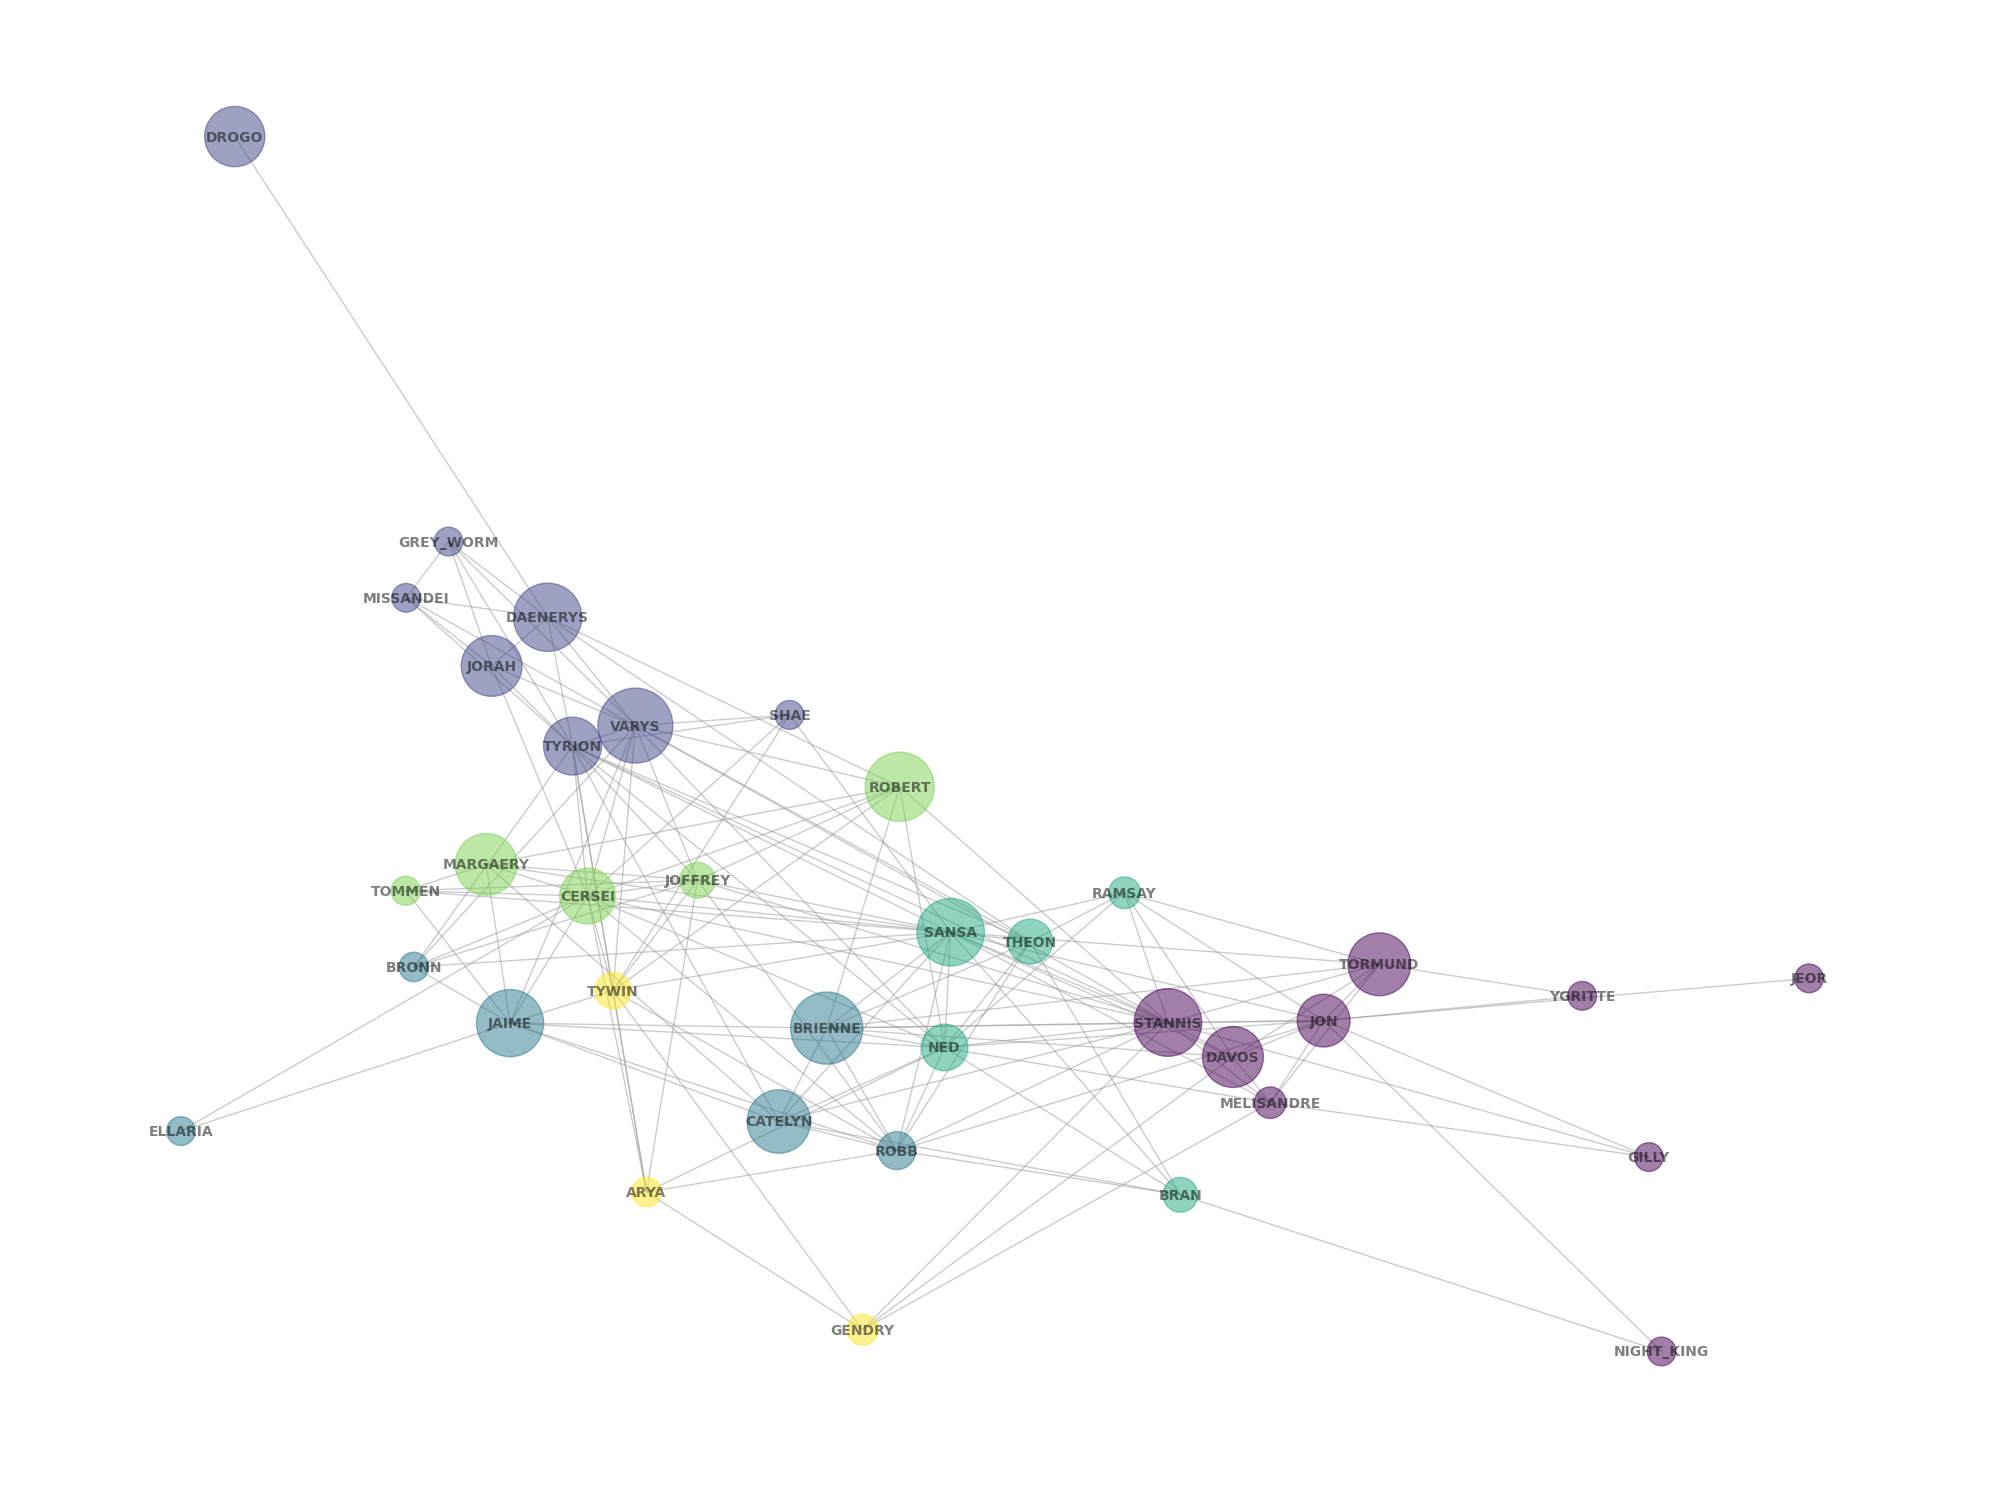

In [35]:
#Season we want to generation
made_story_season = 8

#
idx = made_story_season - 2
z = model.encoder(per_season_features[idx],
                  per_season_pyg_data[idx].edge_index, 
                  per_season_pyg_data[idx].weight.type(torch.float32))

############
death, war, king, adj_upper = model.decoder.decode(z)

death = clipping(death.detach()).reshape(-1)
war = clipping(war.detach()).reshape(-1)
king = clipping(king.detach()).reshape(-1)
adj_upper = clipping(adj_upper.detach())

adj = get_adj(adj_upper)
print(F.mse_loss(adj, per_season_adj[idx+1]))

adj = adj.numpy()
pred_G = nx.from_numpy_matrix(adj)
draw_graph(pred_G)

In [36]:
print(sum(king == per_season_features[idx+1][:, 0])/42)
print(sum(death == per_season_features[idx+1][:, 1])/42)
print(sum(war == per_season_features[idx+1][:, 2])/42)

tensor(0.8095)
tensor(0.6429)
tensor(0.5714)


adj max is 192.0


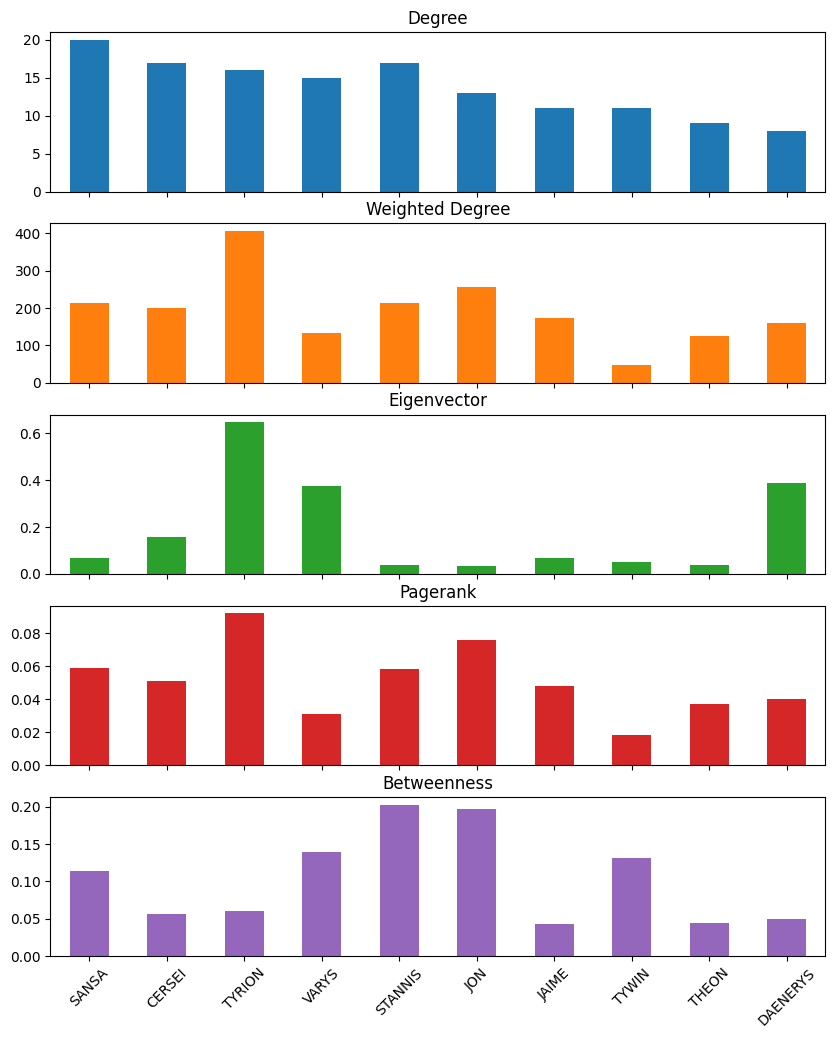

In [37]:
plot_centrality(pred_G, 10)

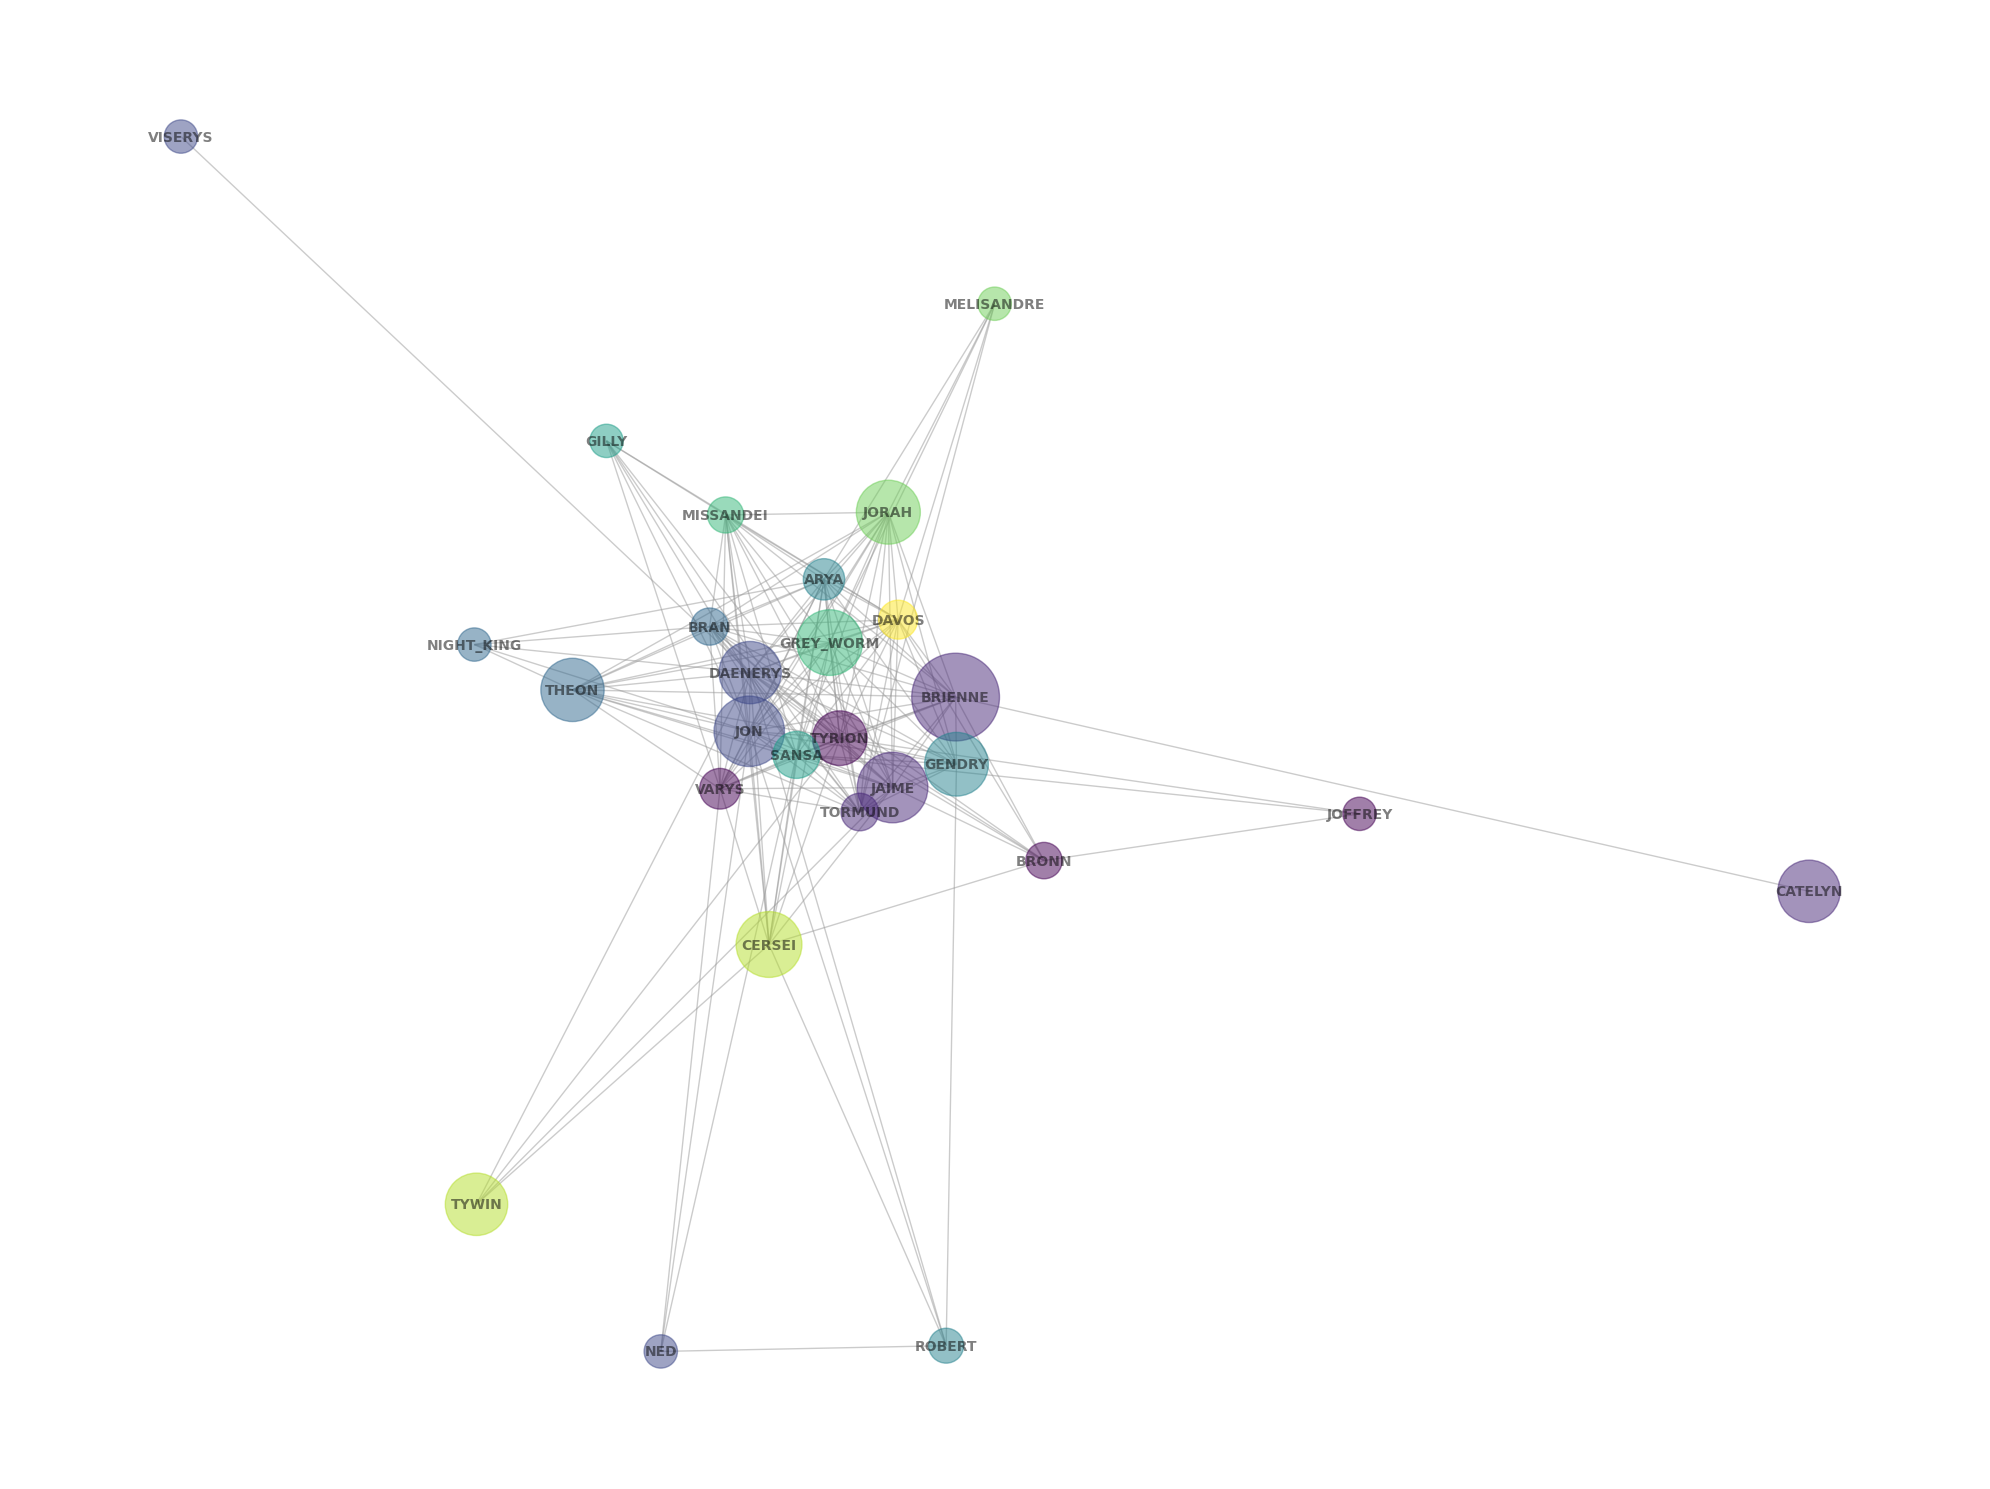

In [38]:
draw_graph(per_season_graph[idx+1])

adj max is 192.0


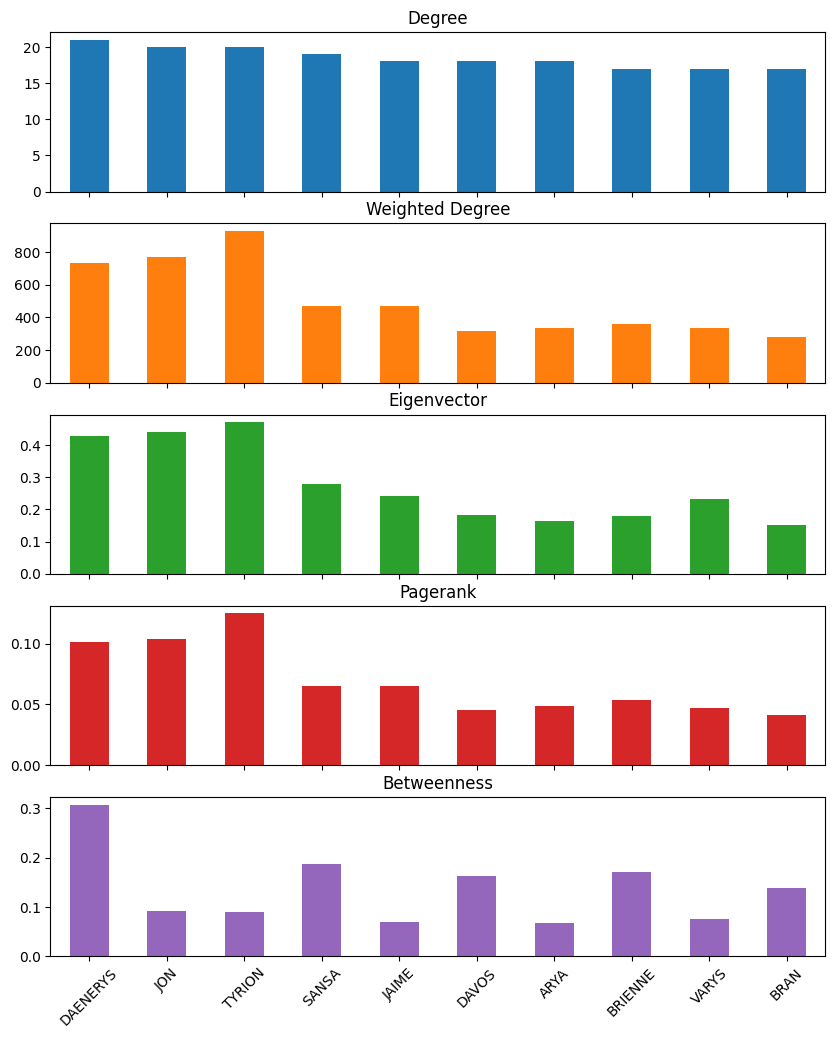

In [39]:
plot_centrality(per_season_graph[idx+1], 10)

# Training Results

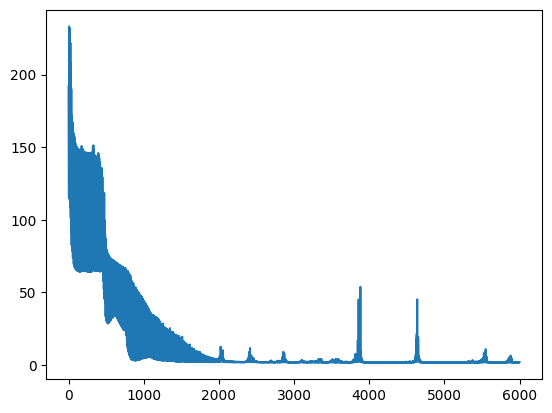

In [40]:
plt.plot(range(EPOCHS * 6), reconstruction_loss)

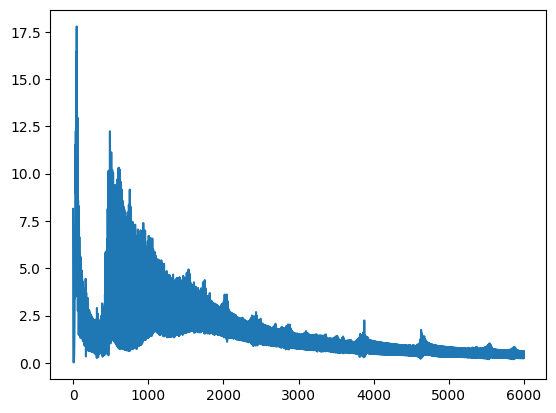

In [41]:
plt.plot(range(EPOCHS * 6), kl_loss)

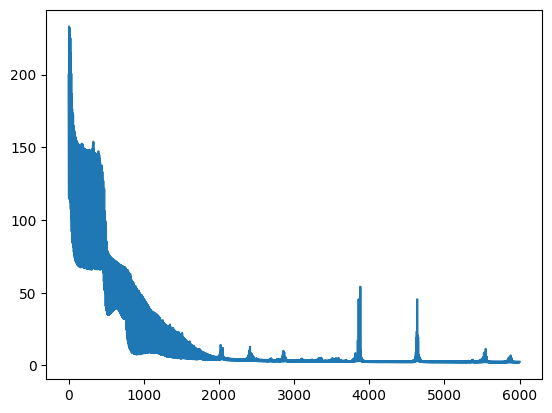

In [42]:
plt.plot(range(EPOCHS * 6), overall_loss)